## Script to calculate time arrival corrections for pump-probe experiments at X-ray Free-Electron-Laser (XFEL) facilities - version adapted to LCLS, SLAC Stanford

### This netebook can ran only during the experiment when access to data is granted (does not work offline!)

Story about: Laser pump pulse triggers time evolution of physical changes in the materials which temporal characteristics are under investigation. X-ray probe pulse (~10 femtosecond) is sent to that material sample with a tailored delay in regard to the pump to measure in detection the instantaneous state of the material. Such experiment/event is repeated for each selected delay with many Xray/laser shots to build statistic. Neverthless, intrinsic jitter between shot-to-shot arrivals of X-ray and laser pulses can be in the range of a few hundreads of femtoseconds at the best facilities. This netebook picks data recorded from a specially designed TimeTool (tt) setup to de-jitter the time arrivals to approach real shot-to-shot time delays between X-ray and laser pulses. Correlating those real delay times with the experimenters signals allow in turn retrieving of the underlaying experiment temporal physical/chemical/biological phenomena.


In [199]:
# Imports

####### 
# psana is a native module of SLAC, Stanford to access data aquisition systems
#######
from psana import *
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import h5py
import os

%matplotlib inline

In [219]:
# Pick data for TimeTool (tt) scan corresponding to XFEL run no. 223

run = '223'
path = os.path.join('/reg/neh/home/dgarratt/TestScripts')
inputFileName = os.path.join(path,'crossCorrelationPreProcessed_two'+str(run)+'.h5')
#inputFileName = os.path.join(path,'tst'+str(run)+'.h5')
print inputFileName
f = h5py.File(inputFileName, 'r')
f.keys()

/reg/neh/home/dgarratt/TestScripts/crossCorrelationPreProcessed_two223.h5


[u'ebeam',
 u'event_time',
 u'evr',
 u'fiducials',
 u'gas_detector',
 u'nomDelay',
 u'offsetPos',
 u'pdVoltage',
 u'phase_cav',
 u'targetTime',
 u'ttAmp',
 u'ttFWHM',
 u'ttPos',
 u'ttStagePos']

7476


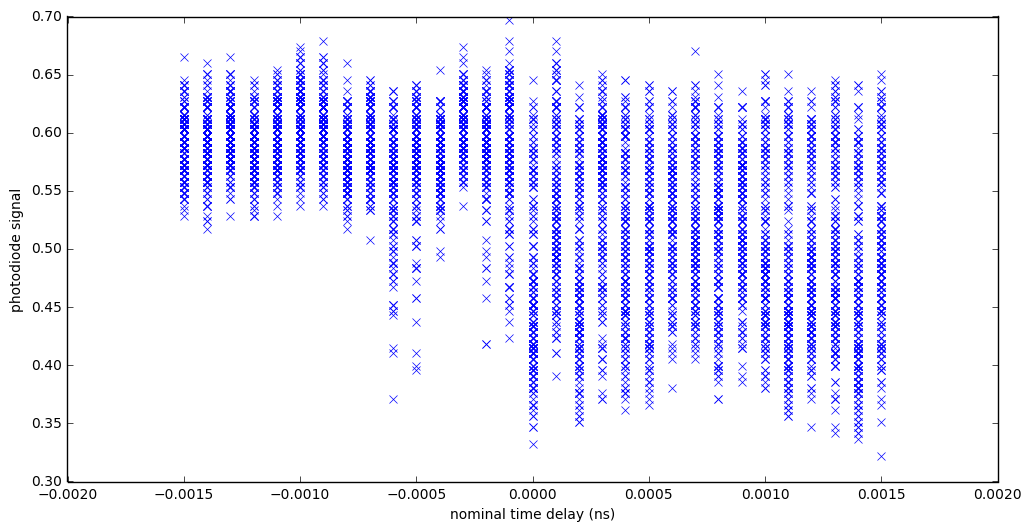

In [248]:
# Estimate position of experimental delay stage (it shifts laser arrival time) to overlap X-rays with laser in time on the sample surface

""""
Cross-correlation scan is performed to find time overlap of X-rays and laser on the sample (laser arrival time 
is fixed and X-ray pulse arrival is ahead or delayed with tailored steps) in the sample interaction plane where 
a sensor was placed giving a photodiode signal proportional to a degree of X-ray and laser pulse overlap. 

In the below figure positive experimental delays means X-rays come first and 'metalize'
the sensor which transmission to a laser then is decreased (lower photodiode signals after the sensor). 
Arrival time distribution per fixed delay reflects intrinsic jitter of the laser pulse arrival that is 
to be estimated and used to correct experimental (nominal) delays which is this notebook is for. 
Nominal time zero (best temporal overlap of the beams) showes the lowest photodiode signals in the figure - due to
highest laser absorption and strong X-ray absorption (and metalization) in coincidence with the laser pulse. 
""""

photodiode = np.array(f['pdVoltage'])
print len(photodiode)
nom_delays_ns = np.array(f['nomDelay'])
nom_delays_fs = np.array([(10**6)*nom_delays_ns[i] for i in range(len(nom_delays_ns))])
target_time_ns = np.array(f['targetTime'])
target_time_fs = np.array([(10**6)*target_time_ns[i] for i in range(len(target_time_ns))])
ttAmp = np.array(f['ttAmp'])
ttFWHM = np.array(f['ttFWHM'])
ttPos = np.array(f['ttPos'])
offsetPos = np.array(f['offsetPos'])
plt.figure(figsize = (12,6))
#plt.plot(nom_delays_fs,photodiode, 'x')
#print nom_delays_fs[10000:11000]
#mskDelays = np.array([round(nom_delays_fs[i])==900 for i in range(len(nom_delays_fs))])
#plt.plot(ttPos[mskDelays],photodiode[mskDelays], 'x')
plt.plot(nom_delays_ns,photodiode, 'x')
plt.xlabel('nominal time delay (ns)')
plt.ylabel('photodiode signal')

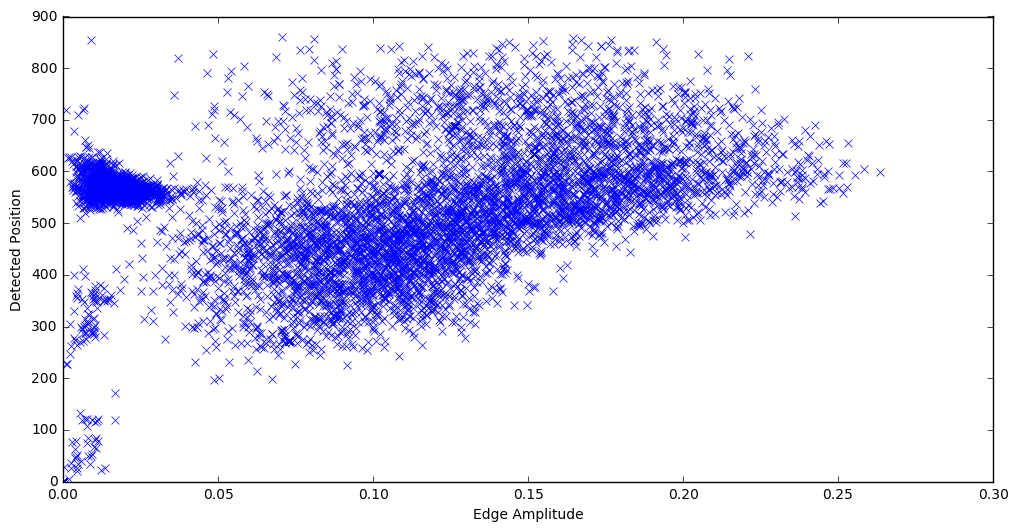

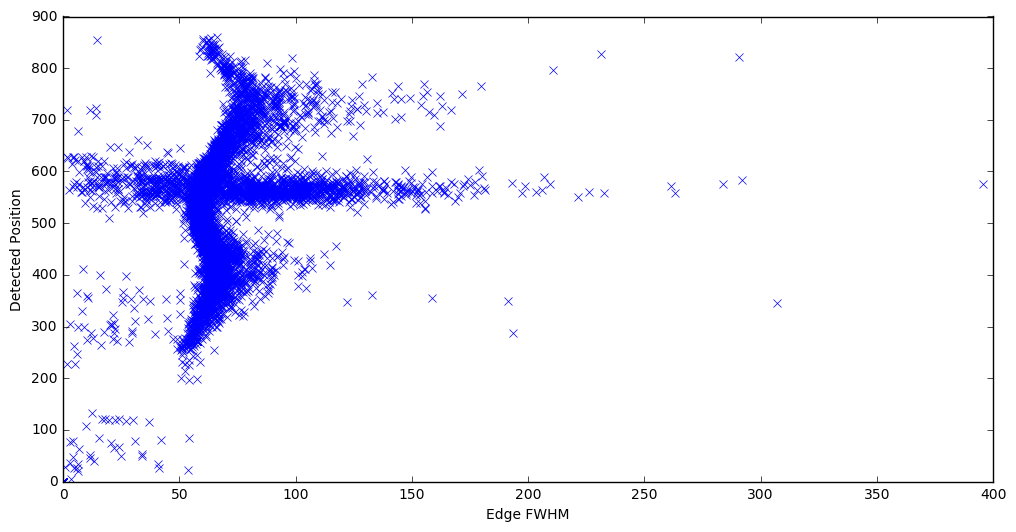

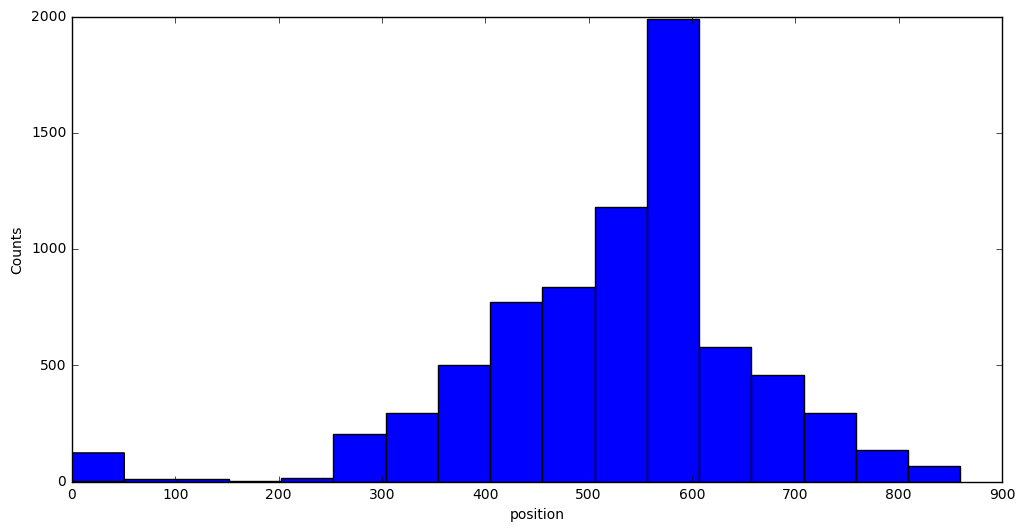

In [221]:
# For scans in run no. 223 draw histogram of tt edge position to estimate tt jitter and average position

"""" 
TimeTool (tt) camera records 2D signal trace (see exemplary trace in cell [198]) when X-ray and laser beams overlap on the camera. 
The peak intensity in the trace indicates time zero crossing in time of X-ray and laser beams.
""""

plt.figure(figsize=(12,6))
plt.plot(ttAmp,ttPos, 'x')
plt.xlabel('Edge Amplitude')
plt.ylabel('Detected Position')
plt.figure(figsize=(12,6))
plt.plot(ttFWHM,ttPos, 'x')
plt.xlabel('Edge FWHM')
plt.ylabel('Detected Position')
plt.xlim((0,400))
minPos = min(ttPos)
maxPos = max(ttPos)
binSize = 50
nBins = round((maxPos-minPos)/binSize)
plt.figure(figsize = (12,6))
plt.hist(ttPos,nBins)
plt.xlabel('position')
plt.ylabel('Counts')

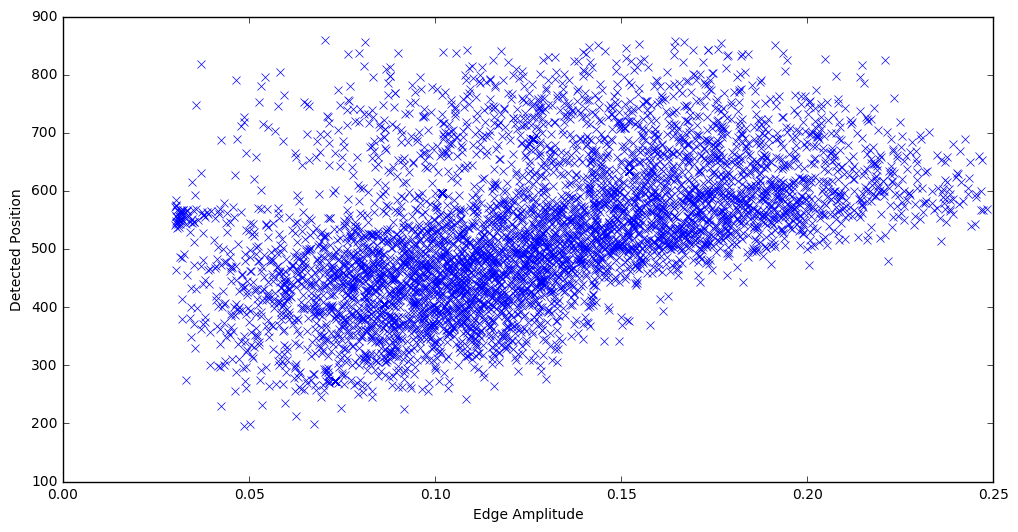

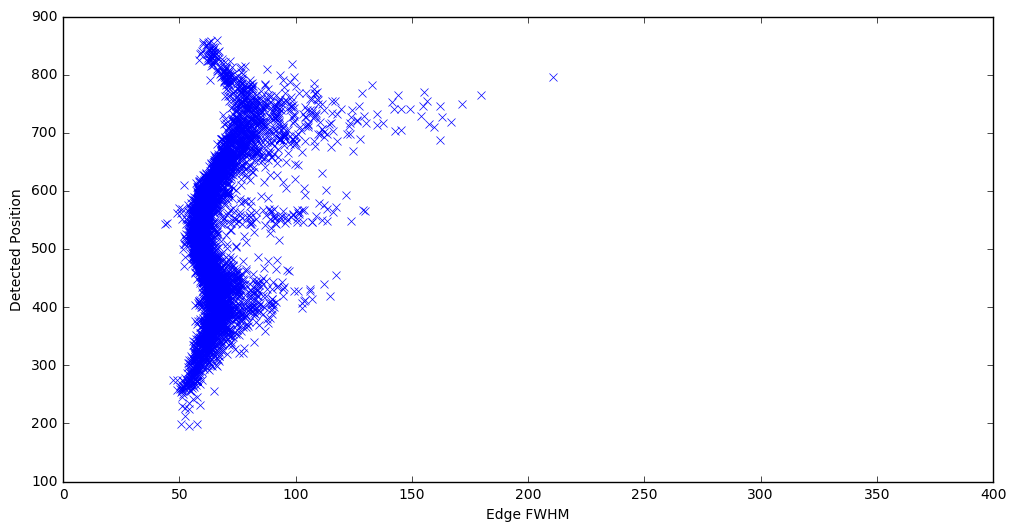

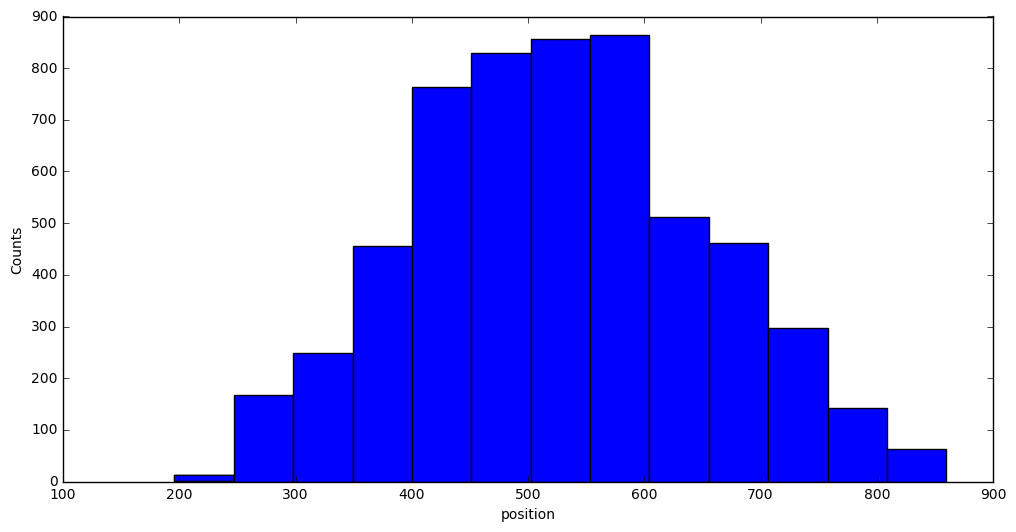

In [223]:
# Remove outliers/artefacts from above tt scan data

fwhmLims = [0,220]
ampLims = [0.03,0.25]
fwhmMask = np.array([fwhmLims[0]<ttFWHM[i]<fwhmLims[1] for i in range(len(ttFWHM))])
ampMask = np.array([ampLims[0]<ttAmp[i]<ampLims[1] for i in range(len(ttAmp))])
mask = fwhmMask*ampMask
plt.figure(figsize=(12,6))
plt.plot(ttAmp[mask],ttPos[mask], 'x')
plt.xlabel('Edge Amplitude')
plt.ylabel('Detected Position')
plt.figure(figsize=(12,6))
plt.plot(ttFWHM[mask],ttPos[mask], 'x')
plt.xlabel('Edge FWHM')
plt.ylabel('Detected Position')
plt.xlim((0,400))
minPos = min(ttPos[mask])
maxPos = max(ttPos[mask])
binSize = 50
nBins = round((maxPos-minPos)/binSize)
plt.figure(figsize = (12,6))
plt.hist(ttPos[mask],nBins)
plt.xlabel('position')
plt.ylabel('Counts')

524.423916736
0.00309283297839


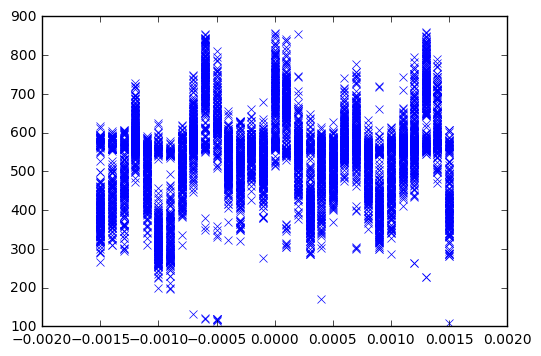

In [243]:
# Get from TimeTool data the shot-to-shot laser arrival time in regard to X-ray arrival and return it in femtoseconds 
# (converted from edge position x on camera). And use it to correct experimental delays (target_time_fs) 

def calibTT(x):
    a = -1.368535
    b =  0.003125841978
    c = -0.000000984393
    tt_correction = a + b*x + c*x**2
    return tt_correction*1000
plt.figure()
meanTT = np.mean(ttPos)

# Print average tt edge position
print meanTT

# Print average arrival time [fs] corresponding to average tt edge position [um]
print calibTT(meanTT)

#mskTT = np.array([950>ttPos[i]>100 for i in range(len(ttPos))],dtype = bool)
#plt.plot(nom_delays_ns[mskTT],ttPos[mskTT], 'x')
calibratedTTPos = np.array([calibTT(ttPos[mask][i]) for i in range(len(ttPos[mask]))])
#plt.plot(nom_delays_ns[mskTT],calibratedTTPos[mskTT], 'x')
correctedDelays = np.array([target_time_fs[i]+calibratedTTPos[i] for i in range(len(ttPos))])
#mskTT = np.array([650>ttPos[i]>50 for i in range(len(ttPos))],dtype = bool)
#plt.plot(nom_delays_ns,calibratedTTPos, 'x')

-2.22044604925e-16
[  0.59030455  -0.08777628   6.03272804 -44.79894408]


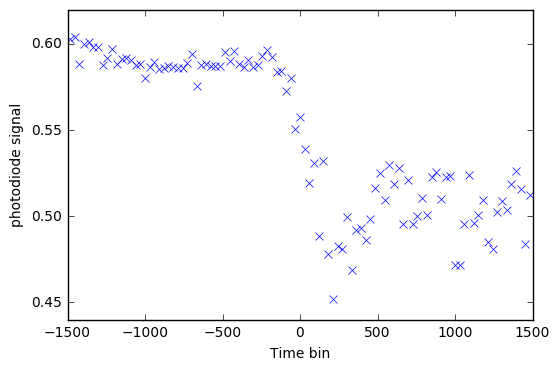

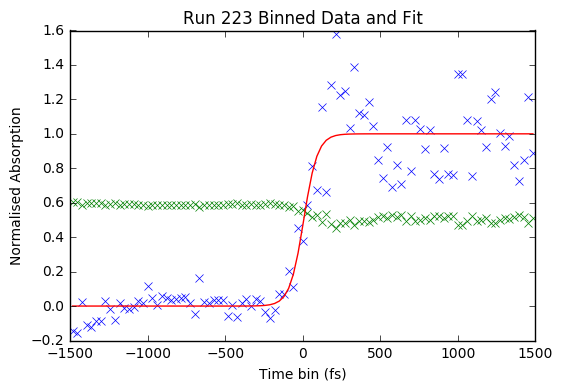

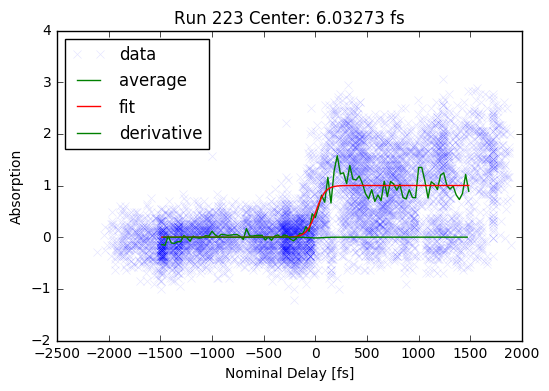

In [245]:
# Correct time zero obtained from scans by correction coming from a physical model of absorption dynamics in the sensor

'''After de-jitterring fit sigmoid function (cumulative statistic) to absorption vs. delays distribution 
   (red curve) to estimate time zero (time overlap of X-rays with laser) matching a physical model of 
   the absorption distribution calculated in a separate notebook.
'''
edges=np.linspace(-1500,1500,100)
centers=(edges[0:-1]+edges[1:])/2
bins=(np.digitize(correctedDelays[mskTT],edges)-1)

N=len(centers)
data=np.zeros(N,dtype=np.float32)
for i in range(N):
    data[i]=photodiode[mskTT][bins==i].mean()
plt.plot(np.sort(centers),data,'x')
plt.xlabel("Time bin")
plt.ylabel('photodiode signal')
x = np.sort(centers)
y = data

def sigmoid(x, low, high, d, k):
    y = high / (1 + np.exp(-(x-d)/np.abs(k))) + low
    return y

low = min(y)
high = max(y)
d=375
k=(max(x)-min(x))/10
popt,pcov = curve_fit(sigmoid,np.sort(x),y,p0=[low,high,d,k])
dataNorm = (data-popt[0])/popt[1]
plt.figure()
plt.plot(np.sort(x),(data-popt[0])/popt[1],'x')
plt.plot(np.sort(centers),data,'x')
plt.plot(np.sort(x),(sigmoid(np.sort(x),*popt)-popt[0])/popt[1])
plt.xlabel("Time bin (fs)")
plt.ylabel('Normalised Absorption')
plt.title('Run ' + str(run) +' Binned Data and Fit')

plt.figure()
plt.plot(correctedDelays[mskTT], (photodiode[mskTT]-popt[0])/popt[1], marker='x',linestyle='',alpha=0.1,label='data')
plt.plot(centers, (data-popt[0])/popt[1],'g',label='average')

#plt.plot(np.sort(x),step(np.sort(x),*popt))
plt.plot(np.sort(x),(sigmoid(np.sort(x),*popt)-popt[0])/popt[1],'r',label='fit')

centers2=(centers[0:-1]+centers[1:])/2
diff=np.diff(sigmoid(np.sort(x),*popt))
print max(diff)
plt.plot(centers2,(diff),label='derivative')

plt.xlabel('Nominal Delay [fs]')
plt.ylabel('Absorption')
plt.title('Run ' + str(run) +' Center: %g fs'%popt[2])
plt.legend(loc=0)

print popt

In [191]:
# Some savings

outPath = os.path.join('/reg/d/psdm/cxi/cxilr2316/scratch/Timing/runs',str(run))
if not os.path.exists(outPath):
    os.makedirs(outPath)
out_fileBinned = os.path.join(outPath , 'crossCorrelationBinned.txt')
out_fileBinnedNorm = os.path.join(outPath , 'crossCorrelationBinnedNorm.txt')
print out_fileBinned
#np.savetxt(out_fileBinned, [centers, data])
np.savetxt(out_fileBinnedNorm, [centers, dataNorm])
print out_fileBinned
np.savetxt(out_fileBinned, [centers, data])

/reg/d/psdm/cxi/cxilr2316/scratch/Timing/runs/64/crossCorrelationBinned.txt
/reg/d/psdm/cxi/cxilr2316/scratch/Timing/runs/64/crossCorrelationBinned.txt


Analyzing in-range 17744 events
saving raw calibration data --> /reg/neh/home/dgarratt/tt_calib_data_cxilr2316_r67.txt

FIT RESULTS
ps_result = a + b*x + c*x^2,  x is edge position
------------------------------------------------
a = -1.397496607103
b = 0.003125841962
c = -0.000000984393
R^2 = 0.487372
------------------------------------------------
fit range (tt pixels): 50 <> 950
time range (fs):       -0.001244 <> 0.000684
------------------------------------------------


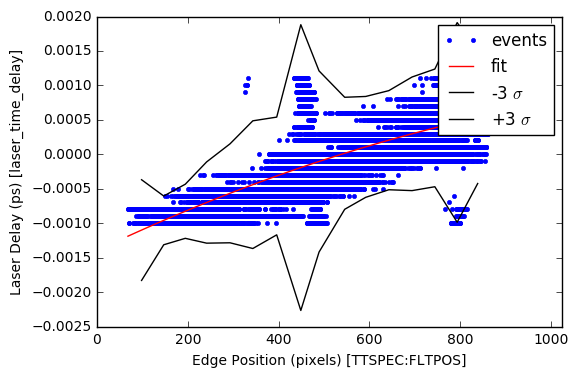

In [206]:
# Get a position of the beams on a detector to arrival time conversion 

analyze_calibration_run('cxilr2316', 67, 'laser_time_delay',px_cutoffs=(50, 950))

Analyzing in-range 16912 events
saving raw calibration data --> /reg/neh/home/dgarratt/tt_calib_data_cxilr2316_r67.txt

FIT RESULTS
ps_result = a + b*x + c*x^2,  x is edge position
------------------------------------------------
a = 4395387.357016706839
b = 0.003742605183
c = -0.000001498481
R^2 = 0.423113
------------------------------------------------
fit range (tt pixels): 200 <> 950
time range (fs):       4395.388046 <> 4395.389560
------------------------------------------------


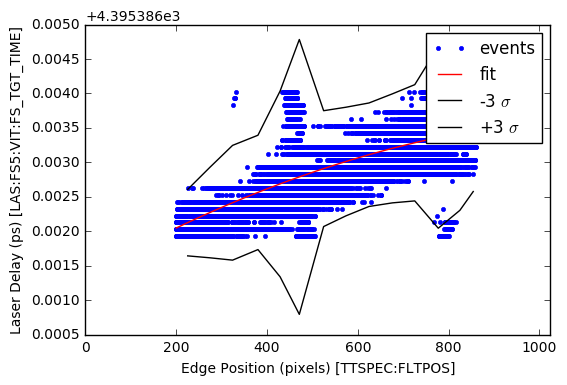

In [42]:
# Get the position-time conversion again for some other scan

analyze_calibration_run('cxilr2316', 67, 'LAS:FS5:VIT:FS_TGT_TIME',px_cutoffs=(50, 950))

In [ ]:
analyze_calibration_run('cxilr2316', 37, 'laser_time_delay',px_cutoffs=(50, 650))

In [31]:
# Function to convert the edge position to arrival time 

def calibTT(x):
    """
    Translate edge position into fs 
    evt is the event code
    from docs >> fs_result = a + b*x + c*x^2, x is edge position
    """
    a = -1.072204400400
    b =  0.006147550573
    c = -0.000009858842
    tt_correction = a + b*x + c*x**2
    return tt_correction

In [32]:
# Estimate method's error metrics

def fit_errors(x, y, y_hat, bin_size):
    """
    Compute errors for fit both 'locally' and 'globally'.
    Specifically, the R^2 statistic is computed as usual (global).
    Additionally, the data are binned across the domain (x > bin_size)
    and for each bin an RMSE is computed.
    Parameters
    ----------
    x, y, y_hat : np.ndarray
       Equal-length 1D arrays of the domain, range, and prediction
       respectively.
    bin_size : float
       The resolution in which to bin `x` for local error computation.
    Returns
    -------
    r_sq : float
        The usual R^2 statistic.
    rmes : np.ndarray
        A 2D array of local errors. The first column is the bin center of
        mass (mean of x's in the bin), the second column is the prediction
        averaged across that bin (mean of y_hat's in the bin), the final
        column is the RMSE for the prediction in that bin.
    Example
    -------
    >>> r_sq, rmes = fit_errors(x, y, y_hat)
    >>> plot(x,y,'.')
    >>> plot(x,y_hat,'-')
    
    >>> plot(rmes[:,0],rmes[:,1] - rmes[:,2],'k-')
    >>> plot(rmes[:,0],rmes[:,1] + rmes[:,2],'k-')
    """

    ssq = lambda x : np.sum(np.square(x))
    
    # global R^2
    ssres = ssq(y - y_hat)
    sstot = ssq(y - np.mean(y))
    r_sq = 1.0 - ssres / sstot
    
    # per-bin RME
    bins = np.arange(x.min(), x.max()+bin_size*2, bin_size)
    assign = np.digitize(x, bins)
    uq = np.unique(assign)
    rmes = np.zeros((len(uq), 3))
    
    # get all x's that fall in a bin & compute rme
    for i,u in enumerate(uq):
        idx = (assign == u) # index of pts in bin
        rmes[i,0] = np.mean(x[idx])
        rmes[i,1] = np.mean(y_hat[idx])
        rmes[i,2] = np.sqrt(ssq( y[idx] - y_hat[idx] ) / np.sum(idx) )
    
    return r_sq, rmes


def analyze_calibration_run(exp, run, las_delay_pvname, px_cutoffs=(200, 800)):
    """
    Analyze a run where the timetool camera is fixed but the laser delay
    changes by a known amount in order to calibrate the TT camera pixel-
    time conversion.
    """

    import psana
    ds = psana.DataSource('exp=%s:run=%d:smd' % (exp, run))


    las_dly = psana.Detector(las_delay_pvname, ds.env())
    tt_edge = psana.Detector('CXI:TTSPEC:FLTPOS', ds.env())
    tt_famp = psana.Detector('CXI:TTSPEC:AMPL', ds.env())
    tt_fwhm = psana.Detector('CXI:TTSPEC:FLTPOSFWHM', ds.env())

    delay_pxl_data = []
    
    for i,evt in enumerate(ds.events()):
        print "analyzing event: %d\r" % (i+1),

        # perform some checks on the fit amplitude and a ful width at half maximum (fwhm)
        if (tt_fwhm(evt) > 300.0) or (tt_fwhm(evt) < 50.0): continue
        if (tt_famp(evt) < 0.1): continue

        edge = tt_edge(evt)
        if (px_cutoffs[0] <= edge) and (edge <= px_cutoffs[1]):
            delay_pxl_data.append([ tt_edge(evt), las_dly(evt) ])

        
    delay_pxl_data = np.array(delay_pxl_data)
    print "Analyzing in-range %d events" % delay_pxl_data.shape[0]

    out_path = os.path.join(os.environ['HOME'],'tt_calib_data_%s_r%d.txt' % (exp, run))
    print "saving raw calibration data --> %s" % out_path
    np.savetxt(out_path, delay_pxl_data)


    # from docs >> fs_result = a + b*x + c*x^2, x is edge position
    fit = np.polyfit(delay_pxl_data[:,0], delay_pxl_data[:,1], 2)
    c, b, a = fit * 1000.0
    p = np.poly1d(fit)

    r_sq, rmes = fit_errors(delay_pxl_data[:,0], delay_pxl_data[:,1], 
                            p(delay_pxl_data[:,0]), 50)

    print "\nFIT RESULTS"
    print "ps_result = a + b*x + c*x^2,  x is edge position"
    print "------------------------------------------------"
    print "a = %.12f" % a
    print "b = %.12f" % b
    print "c = %.12f" % c
    print "R^2 = %f" % r_sq
    print "------------------------------------------------"
    print "fit range (tt pixels): %d <> %d" % px_cutoffs
    print "time range (fs):       %f <> %f" % ( p(px_cutoffs[0]), 
                                                p(px_cutoffs[1]) )
    print "------------------------------------------------"


    x = np.linspace(delay_pxl_data[:,0].min(), delay_pxl_data[:,0].max(), 101)

    # make a plot
    plt.figure()
    plt.plot(delay_pxl_data[:,0], delay_pxl_data[:,1], '.')
    plt.plot(x, p(x),'r-')
    plt.plot(rmes[:,0], rmes[:,1] - rmes[:,2]*3,'k-')
    plt.plot(rmes[:,0], rmes[:,1] + rmes[:,2]*3,'k-')
    plt.legend(['events', 'fit', '-3 $\sigma$', '+3 $\sigma$'])
    plt.xlabel('Edge Position (pixels) [TTSPEC:FLTPOS]')
    plt.ylabel('Laser Delay (ps) [%s]' % las_delay_pvname)
    plt.xlim([0, 1024])

    plt.show()

    return

In [367]:
def analyze_cross_correlation(exp, run, las_delay_pvname, px_cutoffs=(200, 800)):
    """
    Analyze a run where the timetool is running and the laser delay
    changes by a known amount in order to find temporal overlap of x-rays and laser on the sample.
    """

    import psana
    ds = psana.DataSource('exp=%s:run=%d:smd' % (exp, run))

    las_dly = psana.Detector(las_delay_pvname, ds.env())
    tt_edge = psana.Detector('CXI:TTSPEC:FLTPOS', ds.env())
    tt_famp = psana.Detector('CXI:TTSPEC:AMPL', ds.env())
    tt_fwhm = psana.Detector('CXI:TTSPEC:FLTPOSFWHM', ds.env())
    photodiode_det = Detector('CxiEndstation.0:Acqiris.0')
    
    delay_pxl_data = []
    voltage = []
    
    for i,evt in enumerate(ds.events()):
        print "analyzing event: %d\r" % (i+1),

        # perform some checks on the fit amp and fwhm
        if (tt_fwhm(evt) > 300.0) or (tt_fwhm(evt) < 50.0): continue
        if (tt_famp(evt) < 0.05): continue

        edge = tt_edge(evt)
        if (px_cutoffs[0] <= edge) and (edge <= px_cutoffs[1]):
            delay_pxl_data.append([ tt_edge(evt), las_dly(evt) ])
            
            voltage.append(max(photodiode_det.waveform(evt)[1]))

        
    delay_pxl_data = np.array(delay_pxl_data)
    voltage = np.array(voltage)
    print "Analyzing in-range %d events" % delay_pxl_data.shape[0]

    out_path = os.path.join(os.pwd,'tt_calib_data_%s_r%d.txt' % (exp, run))
    print "saving raw calibration data --> %s" % out_path
    np.savetxt(out_path, delay_pxl_data)
    return


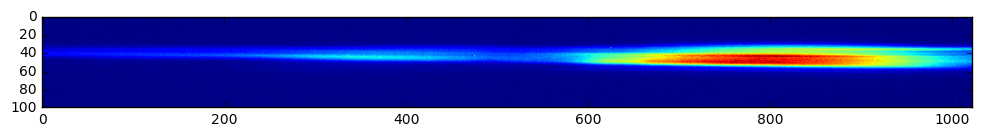

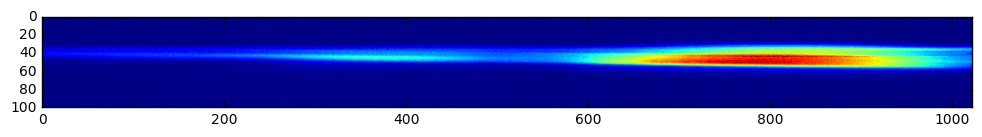

In [198]:
# Draw some traces recorded on the tt camera

ds = DataSource('exp=cxilr2316:run=64')
ttTrace = Detector('Timetool')
for i, evt in enumerate(ds.events()):
    plt.figure(figsize=(12,12))
    plt.imshow(ttTrace.raw(evt))
    if i == 1: break